In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ecg_file = "/home/matthew-lee/Data/fatiguem8/csv/temp.csv"
df = pd.read_csv(ecg_file)
df.head()

,ecg_signal,timestamp,id,session
0,121,1.560763e+09,68fc1ba8befa66a396757ef874f40661,1.560727e+09
1,121,1.560763e+09,68fc1ba8befa66a396757ef874f40661,1.560727e+09
2,121,1.560763e+09,68fc1ba8befa66a396757ef874f40661,1.560727e+09
3,121,1.560763e+09,68fc1ba8befa66a396757ef874f40661,1.560727e+09
4,121,1.560763e+09,68fc1ba8befa66a396757ef874f40661,1.560727e+09


In [4]:
signal = np.array(df["ecg_signal"])

In [5]:
print("Length of signal: {}".format(len(signal)))

Length of signal: 1450944


(<Figure size 1008x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f165bb3d860>)

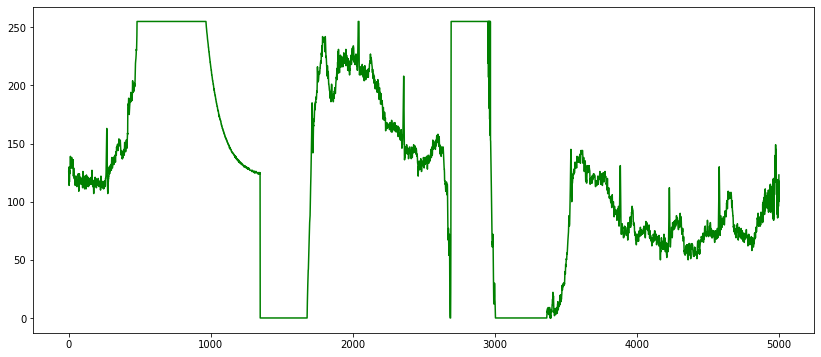

In [6]:
def plot_signal(signal):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(signal, "g")
    return fig, ax

plot_signal(signal[70000:75000])

## Matt's Peak Detection

#### Preprocessing
1. Caculate moving average (Parameter: window)
2. Raise moving average (Parameter: height)
3. Delta between moving average and signal

#### Peak Detection
4. Detect all peaks above delta
5. Group peaks and find highest in area

#### Noise Removal (NH, OH, TH)
6. Check peaks for noise

#### RR Intervals
7. Get rr groups
8. Remove outliers based on baseline

In [223]:
# Preprocessing
def moving_average(signal, window=30):
    a = np.pad(signal, [1, window-2], mode="mean")
    ret = np.cumsum(a, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window

def moving_average_delta(signal, moving_average):
    delta = []
    for a, s in zip(moving_average, signal):
        d = s - a
        delta.append(d)
    return delta

def flatten_moving_average_delta(moving_average_delta, min_threshold=2, max_threshold=20):
    result = []
    for a in moving_average_delta:
        if a < min_threshold:
            result.append(0)
        elif a >= min_threshold and a <= max_threshold:
            result.append(1)
        else:
            result.append(0)
    return result

# Peak Detection
def detect_peaks(moving_avg_delta):
    peaks = [i for i, n in enumerate(moving_avg_delta) if n > 0]
    return peaks

def peak_grouping(peaks, signal, min_dist=100):
    peaks = list(set(peaks))
    peaks.sort()
    sections = []
    section = []
    for i in range(len(peaks)-1):
        section.append(peaks[i])
        peak_delta = peaks[i+1] - peaks[i]
        if peak_delta > min_dist:
            sections.append(section)
            section = []
    sections.append(section)
    return sections

def consolidate_peak_groups(signal, groups):
    peak_indexes = []
    for group in peak_groups:
        if len(group) > 1:
            group.sort()
            slice = signal[group[0]:group[-1]]
            slice_peak = np.argmax(slice)
            peak_index = slice_peak + group[0]
            peak_indexes.append(peak_index)
    return peak_indexes

# Noise and Outlier Removal
def remove_noise(peaks, signal):
    new_peaks = []
    for p in peaks:
        s = signal[p-25:p+35]
        std = np.array(s).std()
        if std < 17:
            new_peaks.append(p)
    return new_peaks

# RR Intervals
def get_rr_groups():
    pass

def remove_rr_outliers(rr):
    pass


In [224]:
sig_section = signal[70000:75000]

In [225]:
mov_avg = moving_average(sig_section) + 20

### Moving Average

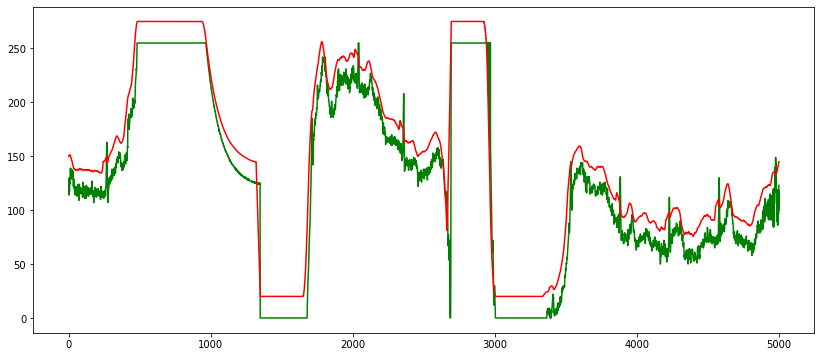

In [226]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(sig_section, "g")
ax.plot(mov_avg, "r")

In [227]:
mov_avg_delta = moving_average_delta(sig_section, mov_avg)
delta_flat = flatten_moving_average_delta(mov_avg_delta)

### Delta of Moving Average and Signal

The difference between the moving average and signal (Blue). The flattened based on range (Red) to accentuate the peaks

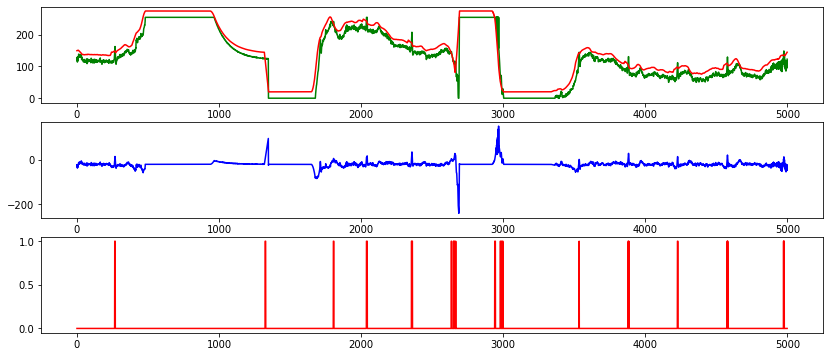

In [228]:
fig, ax = plt.subplots(nrows=3, figsize=(14, 6))
ax[0].plot(sig_section, "g")
ax[0].plot(mov_avg, "r")
ax[1].plot(mov_avg_delta, "b")
ax[2].plot(delta_flat, "r")

### Peak Detection

Peak detection using the moving average delta (Flattened). Groups are discovered of multiple peaks in a small space. Peak groups are consolidated by finding the largest point within the group.

In [229]:
peaks = detect_peaks(delta_flat)

In [230]:
peak_groups = peak_grouping(peaks, sig_section)
peak_groups

[[266, 267, 268, 269],
 [1325, 1326, 1327, 1328],
 [1805, 1806, 1807, 1808],
 [2038, 2039, 2040, 2041, 2042, 2043],
 [2355, 2356, 2360, 2361],
 [2635, 2636, 2637, 2651, 2655, 2656, 2657, 2658, 2666],
 [2941, 2942, 2943, 2944, 2945, 2980, 2981, 2982, 2989, 2990, 2997, 2998],
 [3535],
 [3880, 3881, 3885],
 [4227, 4228, 4229, 4230],
 [4577, 4578, 4580, 4581],
 [4974, 4976]]

In [231]:
peaks = consolidate_peak_groups(sig_section, peak_groups)
peaks

[268, 1325, 1806, 2038, 2358, 2635, 2941, 3882, 4228, 4579, 4974]

In [232]:
def plot_peaks(peaks, signal):
    fig, ax = plt.subplots(figsize=(14, 4))
    y_peaks = [signal[x] for x in peaks]
    ax.plot(signal, 'g')
    ax.plot(peaks, y_peaks, 'ro')
    return fig, ax

(<Figure size 1008x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f163cd7e6d8>)

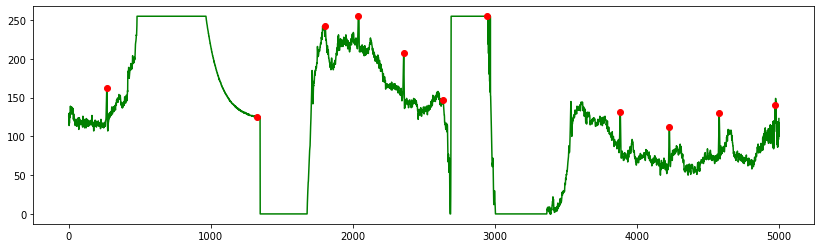

In [233]:
plot_peaks(peaks, sig_section)

### Remove Noise

Calculate the standard deviation of the area surrounding each peak. If standard deviation is larger than a threshold, remove that point. This removes sections of extreme noise

In [234]:
peaks_no_noise = remove_noise(peaks, sig_section)

(<Figure size 1008x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f163cb05978>)

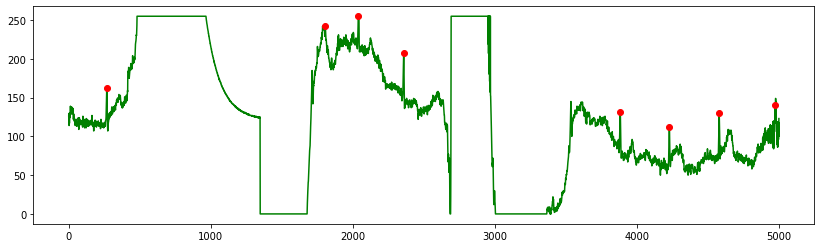

In [235]:
plot_peaks(peaks_no_noise, sig_section)